In [34]:
import pandas as pd 
import numpy as np 
from os import listdir as ls
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import copy

In [2]:
#pre processing functions 
class OneHotEncoder:
    def __init__(self, categories):
        self.categories = categories
        self.category_to_index = {category: i for i, category in enumerate(categories)}
        self.num_categories = len(categories)

    def encode(self, category):
        if category not in self.category_to_index:
            raise ValueError(f"Category '{category}' not found in the provided categories.")
        else:
            encoded_vector = np.zeros(self.num_categories, dtype=np.float32)
            encoded_vector[self.category_to_index[category]] = 1
            return encoded_vector
            
def get_top_n_pers(seasons_pers, n): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in seasons_pers['season'].unique():
        subset = seasons_pers[seasons_pers['season'] == season]
        roster_pers[season] = {}
        for team in teams:
            team_subset = subset[subset['team_id'] ==  team]
            team_subset = team_subset.sort_values(by='per', ascending=False)
            roster_pers[season][team] = np.float32(team_subset['per'].iloc[:n]).flatten()
    return roster_pers

def get_p_stat(data, n, stat): # can adjust to get pers of past seasonm on the new seasons roster
    roster_pers = {}
    for season in data['season'].unique():
        subset = data[data['season'] == season]
        roster_pers[season] = {}
        for team in teams_roster:
            team_subset = subset[subset['Tm'] ==  team]
            team_subset = team_subset.sort_values(by=stat, ascending=False)
            roster_pers[season][team] = team_subset[stat].iloc[:n]
    return roster_pers
    
def get_season(season_string):
    cleaned_reg_season = season_reg.copy()
    columns = season_reg.columns
    date_features = ['date']
    string_features = [ 'home_team', 'away_team', 'arena']
    numeric_features = [ c for c in columns if c not in string_features + date_features]
    cleaned_reg_season[numeric_features] = cleaned_reg_season[numeric_features].apply(pd.to_numeric)
    cleaned_reg_season[date_features] = cleaned_reg_season[date_features].apply(pd.to_datetime)
    start_date, end_date = f'20{season_string[2:4]}-10',  f'20{season_string[-2:]}-05'
    season = cleaned_reg_season[(cleaned_reg_season["date"] >= start_date) & (cleaned_reg_season["date"] <= end_date)]
    return season
    
def get_past_season(season_name):
    start = int(season_name[0:4])-1
    end = int(season_name[-2:])-1
    prior_season_name = f'{start}-{end}'
    return prior_season_name

def get_team_avgs(season_name):
    prior_season_name = get_past_season(season_name)
    season = get_season(prior_season_name)
    # GET TEAM AVG OF THE WHOLE PAST SEASON 
    team_avg_p ={}
    #home_stats_list  = ['home_team', 'home_fg', 'home_fga', 'home_fg_pct', 'home_fg3', 'home_fg3a', 'home_fg3_pct', 'home_ft', 'home_fta', 'home_ft_pct',
    #                    'home_orb', 'home_drb', 'home_trb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf']
    home_stats_list  = ['home_team',  'home_fga', 'home_fg_pct',  'home_fg3a', 'home_fg3_pct',  'home_fta', 'home_ft_pct',
                        'home_orb', 'home_drb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf']    
    # away_stats_list = ['away_team', 'away_fg', 'away_fga', 'away_fg_pct', 'away_fg3', 'away_fg3a', 'away_fg3_pct', 'away_ft', 'away_fta', 'away_ft_pct', 
    #                     'away_orb', 'away_drb', 'away_trb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']
    away_stats_list = ['away_team',  'away_fga', 'away_fg_pct',  'away_fg3a', 'away_fg3_pct', 'away_fta', 'away_ft_pct', 
                        'away_orb', 'away_drb',  'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf', 'away_pts']    
    count = {}
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        
        if home_stats[0] in team_avg_p.keys():
            team_avg_p[home_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] +=1
        else:
            team_avg_p[home_stats[0]] = home_stats[1:]   
            count[home_stats[0]] =1
        if away_stats[0] in team_avg_p.keys():
            team_avg_p[away_stats[0]]= [round(x + y, 2) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] +=1
        else:
            team_avg_p[away_stats[0]] = away_stats[1:]
            count[away_stats[0]] =1
            
    for team in teams:
        team_avg_p[team] = [x / count[team] for x in team_avg_p[team]] 
        
    #GET ROLLING AVG FOR TEAMS USING EACH GAME OF CURRENT SEASON 
    season = get_season(season_name)
    count = {}
    home_pcol, away_pcol = [], []
    for index, row in season.iterrows():
        home, away = [0]*len(home_stats_list), [0]*len(away_stats_list)
        home_stats, away_stats = row[home_stats_list].tolist(), row[away_stats_list].tolist()
        #current season averages 
        if home_stats[0] not in count.keys():  
            home_pcol.append(team_avg_p[home_stats[0]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]] = 2
        else:
            home_pcol.append([x/count[home_stats[0]] for x in team_avg_p[home_stats[0]]])
            team_avg_p[home_stats[0]]= [(x + y) for x, y in zip(team_avg_p[home_stats[0]], home_stats[1:])]
            count[home_stats[0]]+=1
        if away_stats[0] not in count.keys():  
            away_pcol.append(team_avg_p[away_stats[0]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]] = 2
        else:
            away_pcol.append([x/count[away_stats[0]] for x in team_avg_p[away_stats[0]]])
            team_avg_p[away_stats[0]]= [(x + y) for x, y in zip(team_avg_p[away_stats[0]], away_stats[1:])]
            count[away_stats[0]]+=1
    home_pcol = [np.array(sublist) for sublist in home_pcol]
    away_pcol = [np.array(sublist) for sublist in away_pcol]
    return home_pcol, away_pcol 

In [3]:
def pre_process(season, top_n):
    season_name = season
    season = get_season(season)
    # shuffles data
    # season  = season.sample(frac=1).reset_index(drop=True)
    alt_season = season.copy(deep=True)
    season_numeric = season.drop(["date", "home_team", "away_team", "arena"] , axis=1)
    season_categorical = season[["date", "home_team", "away_team", "arena"]]
    spread = np.float32(season_numeric["home_pts"] - season_numeric["away_pts"])
    alt_season['spread'] = spread
    alt_season['result'] = np.where(alt_season['spread'] > 0, alt_season['home_team'], alt_season['away_team'])
    alt_season = alt_season[["home_team", "away_team", "arena", "result"]]
    nc_home, nc_away = get_team_avgs(season_name)
    # get one hot encodings and player stats 
    home_team, home_pers = [], []
    away_team, away_pers = [], []
    arena, winner = [], []
    row_stats = {}
    for stat in list(player_stats.keys()):
        row_stats["home_"+stat+"_input"] = []
        row_stats["away_"+stat+"_input"] = []

    for index, row in alt_season.iterrows():       
        home_team.append(team_encoder.encode(row.iloc[0]))
        away_team.append(team_encoder.encode(row.iloc[1]))
        arena.append(arena_encoder.encode(row.iloc[2]))
        winner.append(team_encoder.encode(row.iloc[3]))
        # get top n player stats
        if season_name == '2014-15':
            raise Exception('cannot train on games in 2014-15 season, start with the 2015-16 season instead')
        else: 
            prior_season_name = get_past_season(season_name)
        home_pers.append(rosters[prior_season_name][row.iloc[0]])
        away_pers.append(rosters[prior_season_name][row.iloc[1]])
        for stat in list(player_stats.keys()):
            row_stats["home_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[0]])
            row_stats["away_"+stat+"_input"].append(player_stats[stat][prior_season_name][row.iloc[1]])
    # add non player stat data
    row_stats["home_pers_input"] = home_pers
    row_stats["away_pers_input"] = away_pers
    row_stats["home_team_input"] = home_team
    row_stats["away_team_input"] = away_team
    row_stats["home_avg_stats_input"] = nc_home
    row_stats["away_avg_stats_input"] = nc_away
    row_stats["arena_input"] = arena

    #convert to tensors 
    for item in row_stats.keys():
        row_stats[item] = tf.convert_to_tensor(row_stats[item])
        
    return row_stats,  {"spread": spread, "outcome": tf.convert_to_tensor(winner)}

In [4]:
def build_model(x_dict, y_dict, model_name=None, layers=None, activation_function=None, show_summary=False):
    model_name = model_name
    inputs = list(x_dict.keys())
    outputs = list(y_dict.keys())
    input_dict = {}
    l1 = 0 
    for input in inputs:
        input_dict[input] = tf.keras.Input(shape=(x_dict[input].shape[1],), name=input)
        l1+=x_dict[input].shape[1]
        
    concatenated_inputs = tf.keras.layers.concatenate([input_dict[x] for x in list(input_dict.keys())])
    layers = [l1]+layers
    last_h_layer = None
    for i in range(len(layers)):
        units = layers[i]
        if i==0:
            prev_layer = tf.keras.layers.Dense(l1, activation=activation_function)(concatenated_inputs)
        elif i == len(layers)-1:
            last_h_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
        else:
            prev_layer = tf.keras.layers.Dense(units, activation=activation_function)(prev_layer)
    
    concatenated_teams = tf.keras.layers.concatenate([input_dict['home_team_input'], last_h_layer, input_dict['away_team_input']])
    final_calc = tf.keras.layers.Dense(layers[-1], activation=activation_function)(concatenated_teams)
    output_spread = tf.keras.layers.Dense(1, activation="linear", name = 'spread')(concatenated_teams)
    output_outcome = tf.keras.layers.Dense(30, activation="softmax", name = 'outcome')(concatenated_teams)
    model_name = tf.keras.Model(inputs=[input_dict[x] for x in list(input_dict.keys())], outputs=[output_spread, output_outcome])
    model_name.compile(loss={'spread':'mean_squared_error' , 'outcome':categorical_crossentropy}, optimizer=tf.keras.optimizers.Nadam(), metrics=["mean_squared_error", "accuracy"])
    if show_summary ==True:
        model_name.summary()
    tf.keras.backend.clear_session()
    return model_name

In [5]:
# procesing advanced player stats data
# adv_stats= pd.read_csv("advanced_stats_15-23.csv")
# adv_stats= adv_stats.drop(['Unnamed: 0', 'Unnamed: 19', 'Unnamed: 24', 'Rk'], axis = 1)
# team_season = adv_stats[['Tm', "season"]]
# adv_stats= adv_stats.select_dtypes(include='number')
# adv_stats[['Tm', "season"]]= team_season
# adv_stats_processed = adv_stats
# adv_stats_processed
# adv_stats_processed.to_csv("adv_stats_data.csv")
season_reg = pd.read_csv('season_reg.csv') #2014-15 - 2022-23 regular_season matches 
seasons_pers = pd.read_csv('seasons_per_s.csv') #2014-15 - 2022-23 player eficiency ratings
adv_stats = pd.read_csv("adv_stats_data.csv")
adv_stats = adv_stats.drop(['Unnamed: 0'], axis = 1)
adv_stats.rename(columns={'WS/48': 'win_shares_48'}, inplace=True)

In [6]:
teams = season_reg['home_team'].unique()
arenas = season_reg['arena'].unique()
teams_roster = adv_stats["Tm"].unique()
team_encoder = OneHotEncoder(teams)
arena_encoder = OneHotEncoder(arenas)
rosters = get_top_n_pers(seasons_pers, 8)  # rosters[season][team]

player_stats ={}

for stat in adv_stats:
    # create variable for top stat dict ex. rosters_dbpm = get_p_stat(adv_stats, 8, "DBPM"
    if stat != 'Tm' and stat != 'season':
        player_stats[stat] = get_p_stat(adv_stats, 8, stat)

In [7]:
x_train, y_train= pre_process('2017-18', top_n=8)
x_test, y_test= pre_process('2018-19',top_n=8)

In [8]:
unique_elements, counts = np.unique(y_test["spread"], return_counts=True)
print("baseline spread accuracy: ", max(counts)/sum(counts) )
unique_elements, counts = np.unique(np.argmax(y_test["outcome"], axis=1), return_counts=True)
print("baseline outcome accuracy: ", max(counts)/sum(counts) )
# baseline is 5% anythong better is better than random guessing!

baseline spread accuracy:  0.04390243902439024
baseline outcome accuracy:  0.04878048780487805


In [9]:
home_keys = [key for key in x_train if 'home' in key and key != 'home_team_input' and key != 'home_avg_stats_input']
away_keys = [key for key in x_train if 'away' in key and key != 'away_team_input' and key != 'away_avg_stats_input']
core_stats = [key for key in x_train if key not in home_keys and key not in away_keys]
min_stats = ['home_team_input','away_team_input', 'arena_input']
main_v_core = [min_stats, core_stats]

In [10]:
index = 0 
lead_val_loss = 1000
lead_val_acc = 0
for inputs in main_v_core:
    train_data= {}
    l1 = 0
    for input in inputs:
        train_data[input] = x_train[input]
        l1+=x_train[input].shape[1]
    model = build_model(train_data, y_train, model_name = f"model_index:{str(index)}", layers = [l1, l1, l1, l1, 60], activation_function="gelu", show_summary = False)
    history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=100, validation_split = 0.05, verbose = 0)
    cur_loss = min(history.history['val_loss'])
    cur_acc = max(history.history['val_outcome_accuracy'])
    # if cur_loss < lead_val_loss:    
    #     print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}", f" -model_index:{str(index)}")
    # if cur_acc >lead_val_acc:   
    #     print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}", f" -model_index:{str(index)}")
    # print()
    if cur_loss < lead_val_loss:    
        print(f"final loss = {history.history['loss'][-1]}, final validation_loss = {history.history['val_loss'][-1]}", f" -model_index:{str(index)}")
    if cur_acc >lead_val_acc:   
        print(f"final accuracy = {history.history['outcome_accuracy'][-1]}, final validation_accuracy = {history.history['val_outcome_accuracy'][-1]}", f" -model_index:{str(index)}")
    print()
    index+=1 


final loss = 76.72038269042969, final validation_loss = 256.656982421875  -model_index:0
final accuracy = 0.6695205569267273, final validation_accuracy = 0.3870967626571655  -model_index:0

final loss = 137.35523986816406, final validation_loss = 277.1009521484375  -model_index:1
final accuracy = 0.5779109597206116, final validation_accuracy = 0.4354838728904724  -model_index:1



In [11]:
# simple model beats baseline by alot!

In [12]:
# can we beat 32%

In [13]:
# model seems to be overfitting the training data, increasing past seasons for generalization to see if it helps 

In [20]:
x_train_0, y_train_0= pre_process('2016-17', top_n=8)
x_train_1, y_train_1= pre_process('2017-18', top_n=8)
x_test, y_test= pre_process('2018-19',top_n=8)

In [22]:
x_train_0['home_avg_stats_input'][0].shape

TensorShape([13])

In [32]:
x_train_0 = select_features(x_train_0)
l1 = 0
for key in x_train_0:
    l1 += x_train_0[key].shape[1]

model = build_model(x_train_0, y_train_0, model_name='nba_1', layers=[l1, l1,l1, l1,l1], activation_function='gelu', show_summary=True)

model.fit(x_train_0, y_train_0, epochs=50, batch_size=100, validation_split=0.20)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_team_input     │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_avg_stats_inp… │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_avg_stats_inp… │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arena_input         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_AST%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_AST%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_TOV%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_TOV%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_OBPM_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_OBPM_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_FTr_input      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_FTr_input      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_DRB%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_DRB%_input     │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_WS_input       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_WS_input       │ (None, 8)         │          0 │ -               

 Total params: 433,046 (1.65 MB)

 Trainable params: 433,046 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 211.8581 - outcome_accuracy: 0.0386 - spread_mean_squared_error: 206.8092 - val_loss: 192.1330 - val_outcome_accuracy: 0.0610 - val_spread_mean_squared_error: 182.2602
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 196.3082 - outcome_accuracy: 0.0361 - spread_mean_squared_error: 192.5135 - val_loss: 187.0212 - val_outcome_accuracy: 0.0366 - val_spread_mean_squared_error: 178.2816
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 201.3304 - outcome_accuracy: 0.0414 - spread_mean_squared_error: 198.0182 - val_loss: 204.3688 - val_outcome_accuracy: 0.0325 - val_spread_mean_squared_error: 194.3307
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 187.6489 - outcome_accuracy: 0.0538 - spread_mean_squared_error: 184.2766 - val_loss: 192.5755 - val_outcome_accuracy: 0.0691 - val_spread_mean_squared_error: 181.9530
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 183.7882 - outcome_accuracy: 0.06

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


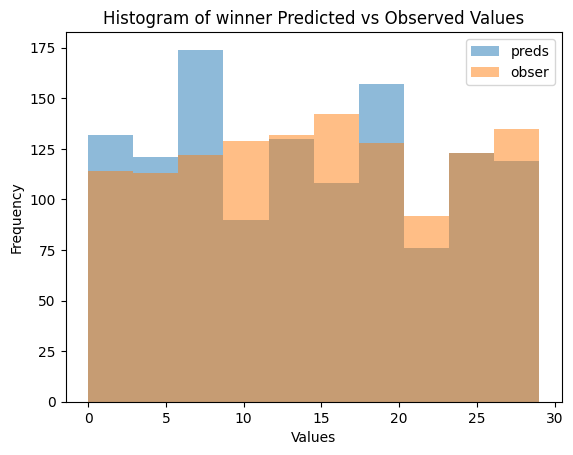

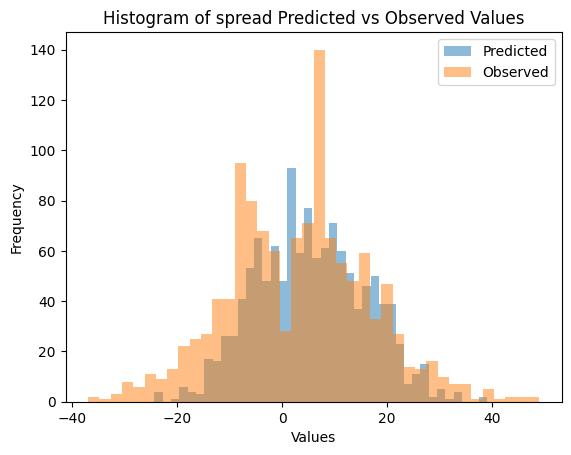

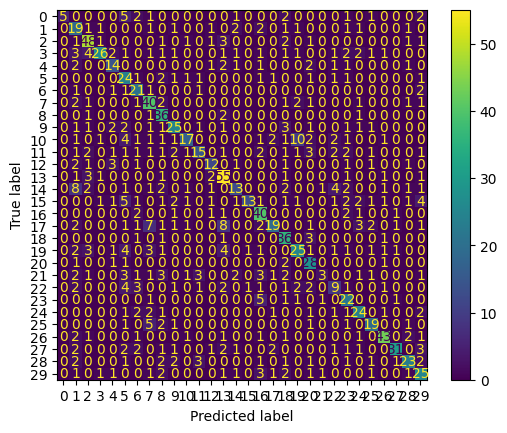

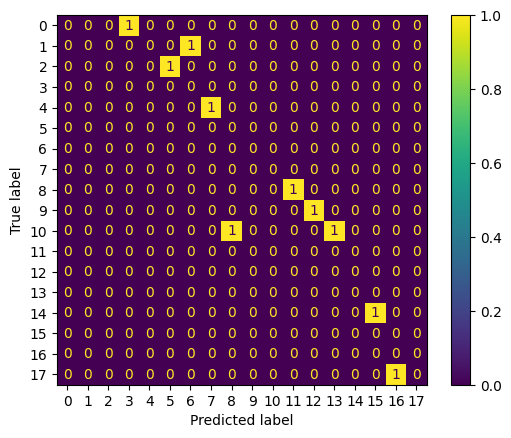

<Figure size 640x480 with 0 Axes>

In [41]:
#look at spread predictions 
predictions = model.predict(x_train_0)
spread = predictions[0]
putcome = predictions[1]
#outcome
predictions = np.argmax(putcome, axis = 1)
plt.hist(np.argmax(putcome,  axis =1), alpha=0.5, label='preds')
 
observed = np.argmax(y_train_0['outcome'],  axis =1)
plt.hist(observed, alpha=0.5, label='obser')
 
plt.legend()
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of winner Predicted vs Observed Values')
plt.show()
 
 
#spread 
plt.hist(spread, bins=40, label='Predicted', alpha=0.5)
plt.hist(y_train_0['spread'], bins=40, label='Observed', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of spread Predicted vs Observed Values')
plt.legend()
plt.show()
 
cm = ConfusionMatrixDisplay(confusion_matrix(observed, predictions))
cm.plot()
plt.show()

cm = ConfusionMatrixDisplay(confusion_matrix(y_train_0['spread'][:10], np.round(spread[:10]).astype(int)))
cm.plot()
plt.show()
plt.savefig('confusion_matrix_spread.png')

In [15]:
def train_input_loop_acc(best_train_data, home_keys, away_keys, lead_val_accuracy):
    print("train_input_loop_i")
    new_btd ={}
    while home_keys != []:
        old_lead_val_accuracy = lead_val_accuracy
        l1 = 0
        for key in best_train_data.keys():
            l1+=best_train_data[key].shape[1]
        for key_idx in range(len(home_keys)):
            train_data= copy.deepcopy(best_train_data)
            # add stats being tested
            train_data[home_keys[key_idx]] = x_train[home_keys[key_idx]]
            train_data[away_keys[key_idx]] = x_train[away_keys[key_idx]]
      
            
            l1 += x_train[home_keys[key_idx]].shape[1]+ x_train[away_keys[key_idx]].shape[1]
            model = build_model(train_data, y_train, model_name = f"model_{key_idx}", layers = [l1, l1, l1, l1], show_summary = False)
            history = model.fit(x=train_data, y=y_train, epochs=50, batch_size=150, validation_split = 0.3, verbose = 0)
            cur_loss = min(history.history['val_loss'])
            cur_acc = max(history.history['val_outcome_accuracy'])
            if cur_acc > lead_val_accuracy:
                lead_val_accuracy = cur_acc
                new_btd = copy.deepcopy(train_data)
                print("\n", train_data.keys())
                model.save('best_model_acc.keras')
                print(f"Best loss = {min(history.history['loss'])}, Best validation_loss = {min(history.history['val_loss'])}")  
                print(f"Best accuracy = {max(history.history['outcome_accuracy'])}, Best validation_accuracy = {max(history.history['val_outcome_accuracy'])}")
                print()
            else:
                print(cur_acc, end =" ")
            l1 = 0
            for key in best_train_data.keys():
                l1+=best_train_data[key].shape[1]
                
    
        if old_lead_val_accuracy != lead_val_accuracy:
            home_keys_c = home_keys.copy()  # Make a copy to avoid modifying the original
            away_keys_c = away_keys.copy()  # Make a copy to avoid modifying the original
            print("best keys")
            print(new_btd.keys())

            for key in new_btd.keys():
                if key in home_keys_c:
                    home_keys_c.remove(key)
                elif key in away_keys_c:  # Fixing this condition
                    away_keys_c.remove(key)
            
            
            return train_input_loop_acc(new_btd, home_keys_c, away_keys_c, lead_val_accuracy)
        else:
            print("best model params above")
            return

In [16]:
# %%capture captured_output            
train_core= {}
for stat in core_stats:
    train_core[stat] = x_train_0[stat]
        
train_input_loop_acc(train_core, home_keys, away_keys, 0)

# with open('data_testing.txt', 'w') as f:
#     f.write(captured_output.stdout)

train_input_loop_i

 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_Age_input', 'away_Age_input'])
Best loss = 179.17909240722656, Best validation_loss = 203.89649963378906
Best accuracy = 0.22648084163665771, Best validation_accuracy = 0.13550135493278503

0.11382114142179489 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_MP_input', 'away_MP_input'])
Best loss = 316.8751525878906, Best validation_loss = 325.3330078125
Best accuracy = 0.25435540080070496, Best validation_accuracy = 0.24119241535663605

0.2249322533607483 0.04878048598766327 0.056910570710897446 0.04878048598766327 
 dict_keys(['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 'arena_input', 'home_ORB%_input', 'away_ORB%_input'])
Best loss = 175.7353515625, Best validation_loss = 208.4266815185547
Best accuracy = 0.3774680495262146, Best valid

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model('best_model_acc.keras')
model.summary()

In [24]:
def select_features(train_data):
    train_subset = {}
    features = ['home_team_input', 'away_team_input', 'home_avg_stats_input', 'away_avg_stats_input', 
                 'arena_input', 'home_AST%_input', 'away_AST%_input', 'home_TOV%_input', 'away_TOV%_input', 
                 'home_OBPM_input', 'away_OBPM_input', 'home_FTr_input', 'away_FTr_input', 'home_DRB%_input', 
                 'away_DRB%_input', 'home_WS_input', 'away_WS_input', 'home_PER_input', 'away_PER_input', 
                 'home_BLK%_input', 'away_BLK%_input']
    
    for key in features:
        train_subset[key]=x_train_0[key]
    return train_subset

In [ ]:
x_train_0, y_train_0= pre_process('2016-17', top_n=8)
x_train_1, y_train_1= pre_process('2017-18', top_n=8)
x_test, y_test= pre_process('2018-19',top_n=8)

x_train_0 = select_features(x_train_0 )
x_train_1 = select_features(x_train_1 )

In [ ]:
# start hyperparameter testing here

In [ ]:
plt.plot(best_model.history['loss'][1:])
plt.plot(best_model.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss_funct_list = ["mse", "sparse_categorical_crossentropy", "mae"]
optimizer_list = ["SGD", "Adamax", "Adagrad"]
activation_list = ["relu", "gelu", "silu", "LeakyReLU"]
last_layer_list = ["softmax", "softplus"]

for x in loss_funct_list:
    model.compile(loss = loss_funct_list)
    for x in optimizer_list:
        model.compile(optimizer = optimizer_list)
        for x in activation_list:
                model.compile(optimizer = activation_list)

loss functions: mse, sparse_categorical_crossentropy, mae

optimizers: SGD, Adamax, Adagrad

activation: relu, gelu, selu, silu, LeakyReLU, softmax, softplus

other layers to try: Drop Out, Batch Normalization

We can also tweak the learning rate in various ways, change the batch size, and try assorted numbers of intermediate layers